<a href="https://colab.research.google.com/github/olley102/CommunityDetectionURSS/blob/main/autoencoder_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder image segmentation
This is an attempt to implement an idea to use autoencoders to encode local spatial information of images to then apply clustering.

## 1. Sliding window autoencoder

In [ ]:
!git clone https://github.com/olley102/CommunityDetectionURSS.git

Cloning into 'CommunityDetectionURSS'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 180 (delta 82), reused 110 (delta 36), pack-reused 0
Receiving objects: 100% (180/180), 2.76 MiB | 10.56 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [ ]:
import sys
sys.path.append('/content/CommunityDetectionURSS')

In [ ]:
from image_processing import nn

## 2. GPWv411 Population Count dataset

In [ ]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 561 kB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls '/content/drive/My Drive/GoogleEarthEngine'

GPW_v411_pc_time0.tif  GPW_v411_pc_time2.tif  GPW_v411_pc_time4.tif
GPW_v411_pc_time1.tif  GPW_v411_pc_time3.tif


In [ ]:
import rasterio

In [ ]:
import numpy as np

In [ ]:
with rasterio.open('/content/drive/My Drive/GoogleEarthEngine/GPW_v411_pc_time0.tif', 'r') as ds:
  time0 = ds.read()

gpw = np.zeros((time0.shape[1], time0.shape[2], 5), dtype='float')
gpw[..., 0] = time0[0]

for i in range(4):
  with rasterio.open(f'/content/drive/My Drive/GoogleEarthEngine/GPW_v411_pc_time{i+1}.tif', 'r') as ds:
    gpw[..., i+1] = ds.read()[0]

gpw[np.isnan(gpw)] = 0.0

In [ ]:
from image_processing import optical_flow

In [ ]:
uv = optical_flow.iteration(gpw, 1, alpha=10, use_previous=True, centering=(0, 0, 0))

In [ ]:
image0 = np.dstack((gpw[..., 0], np.moveaxis(uv[..., 0], 0, -1)))

In [ ]:
image0.shape

(1796, 1105, 3)

## 3. Apply WindowAE

In [ ]:
ae = nn.WindowAE(window_size=(7, 7), num_channels=3)

In [ ]:
ae.auto_decoder_sizes((128, 64, 16))

In [ ]:
ae.decoder_sizes

(64, 128, 147)

In [ ]:
ae.make()
ae.compile()

In [ ]:
# !rm -r /content/checkpoints

In [ ]:
!mkdir /content/checkpoints

In [ ]:
fp = '/content/checkpoints/checkpoint_{epoch}.hdf5'
ae.make_callback(fp, period=10)

In [ ]:
ae.model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7, 7, 5)]         0         
                                                                 
 flatten_1 (Flatten)         (None, 245)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               31488     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 16)                1040      
                                                                 
 activation_1 (Activation)   (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 64)                1088

In [ ]:
ae.encoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7, 7, 5)]         0         
                                                                 
 flatten_1 (Flatten)         (None, 245)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               31488     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 16)                1040      
                                                                 
Total params: 40,784
Trainable params: 40,784
Non-trainable params: 0
_________________________________________________________________


In [ ]:
ae.fit_transform(image0)

In [ ]:
ae.max

array([1000.        ,   19.27732841,   15.56390217])

In [ ]:
ae.min

array([  0.        , -18.43612872, -17.98653061])

In [ ]:
np.sum(image0[..., 0] > 1000) / (image0.shape[0]*image0.shape[1])

0.0

In [ ]:
image0 = np.clip(image0, None, 1000)

In [ ]:
ae.fit_transform(image0)

In [ ]:
ae.max

array([1000.        ,   19.27732841,   15.56390217])

In [ ]:
ae.min

array([  0.        , -18.43612872, -17.98653061])

In [ ]:
history = ae.fit(image0, image0, epochs=200, batch_size=1000)

32/32 [==============================] - 1s 3ms/step - loss: 0.0671 - mse: 0.0671
Epoch 2/2
32/32 [==============================] - 0s 3ms/step - loss: 0.0042 - mse: 0.0042
Epoch 3/3
32/32 [==============================] - 0s 3ms/step - loss: 0.0029 - mse: 0.0029
Epoch 4/4
32/32 [==============================] - 0s 3ms/step - loss: 0.0010 - mse: 0.0010
Epoch 5/5
32/32 [==============================] - 0s 3ms/step - loss: 9.1321e-04 - mse: 9.1321e-04
Epoch 6/6
32/32 [==============================] - 0s 3ms/step - loss: 8.9121e-04 - mse: 8.9121e-04
Epoch 7/7
32/32 [==============================] - 0s 3ms/step - loss: 8.2202e-04 - mse: 8.2202e-04
Epoch 8/8
32/32 [==============================] - 0s 3ms/step - loss: 7.1970e-04 - mse: 7.1970e-04
Epoch 9/9
32/32 [==============================] - 0s 3ms/step - loss: 6.5664e-04 - mse: 6.5664e-04
Epoch 10/10
32/32 [==============================] - 0s 4ms/step - loss: 7.9354e-04 - mse: 7.9354e-04
Epoch 11/11
32/32 [=====================

In [ ]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'mse')

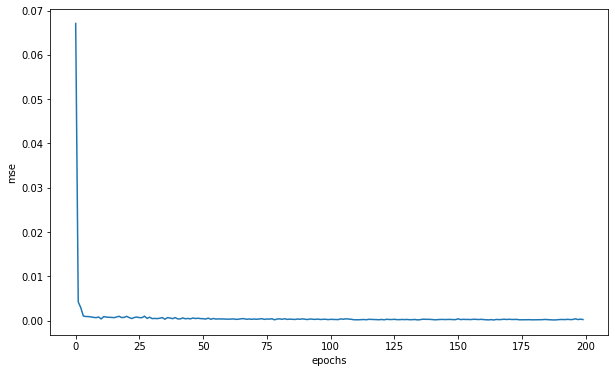

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()
history_arr = [h.history['mse'][0] for h in history]
ax.plot(history_arr)
ax.set_xlabel('epochs')
ax.set_ylabel('mse')

In [ ]:
!cp /content/checkpoints/checkpoint_200.hdf5 /content/drive/My\ Drive/Colab\ Notebooks/Files/checkpoint_200.hdf5

In [ ]:
ae.load_epoch('/content/drive/My Drive/Colab Notebooks/Files/checkpoint_{epoch}.hdf5', 200)

True

In [ ]:
encoding = ae.encode(image0, verbose=True, batch_size=image0.shape[1]*10)

Encoding pixels 0:11050
Encoding pixels 11050:22100
Encoding pixels 22100:33150
Encoding pixels 33150:44200
Encoding pixels 44200:55250
Encoding pixels 55250:66300
Encoding pixels 66300:77350
Encoding pixels 77350:88400
Encoding pixels 88400:99450
Encoding pixels 99450:110500
Encoding pixels 110500:121550
Encoding pixels 121550:132600
Encoding pixels 132600:143650
Encoding pixels 143650:154700
Encoding pixels 154700:165750
Encoding pixels 165750:176800
Encoding pixels 176800:187850
Encoding pixels 187850:198900
Encoding pixels 198900:209950
Encoding pixels 209950:221000
Encoding pixels 221000:232050
Encoding pixels 232050:243100
Encoding pixels 243100:254150
Encoding pixels 254150:265200
Encoding pixels 265200:276250
Encoding pixels 276250:287300
Encoding pixels 287300:298350
Encoding pixels 298350:309400
Encoding pixels 309400:320450
Encoding pixels 320450:331500
Encoding pixels 331500:342550
Encoding pixels 342550:353600
Encoding pixels 353600:364650
Encoding pixels 364650:375700
Enc

In [ ]:
pred = ae.predict(image0, verbose=True, batch_size=image0.shape[1]*10)

In [ ]:
pred.shape

(1796, 1105, 3)

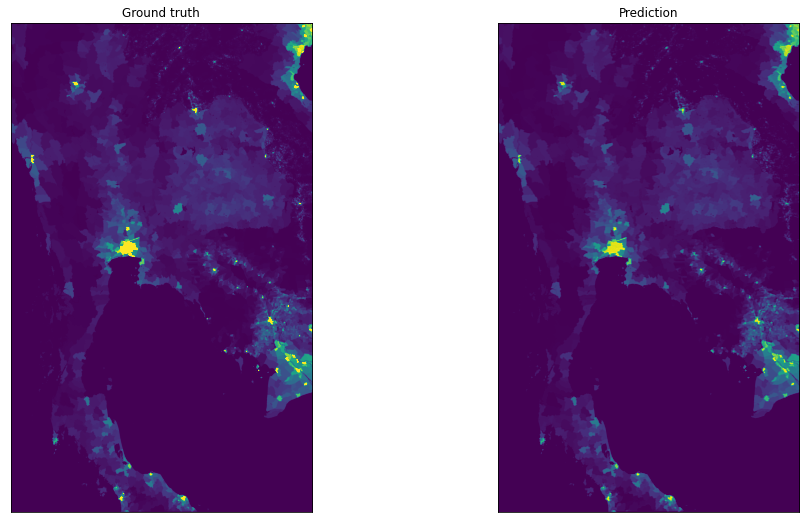

In [ ]:
fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_subplot(121)
im1 = ax1.imshow(gpw[..., 0], vmin=0, vmax=1000)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax1.set_title('Ground truth')

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(pred[..., 0], vmin=0, vmax=1000)
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
ax2.set_title('Prediction')

fig.savefig('windowae_pred')

Text(0.5, 1.0, 'Prediction')

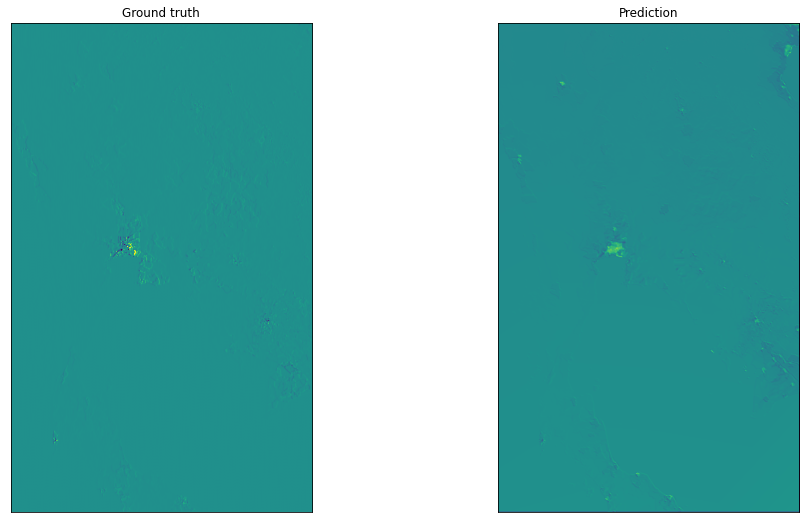

In [ ]:
fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_subplot(121)
im1 = ax1.imshow(uv[0, :, :, 0], vmin=-2, vmax=2)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax1.set_title('Ground truth')

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(pred[..., 1], vmin=-2, vmax=2)
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
ax2.set_title('Prediction')

Text(0.5, 1.0, 'Prediction')

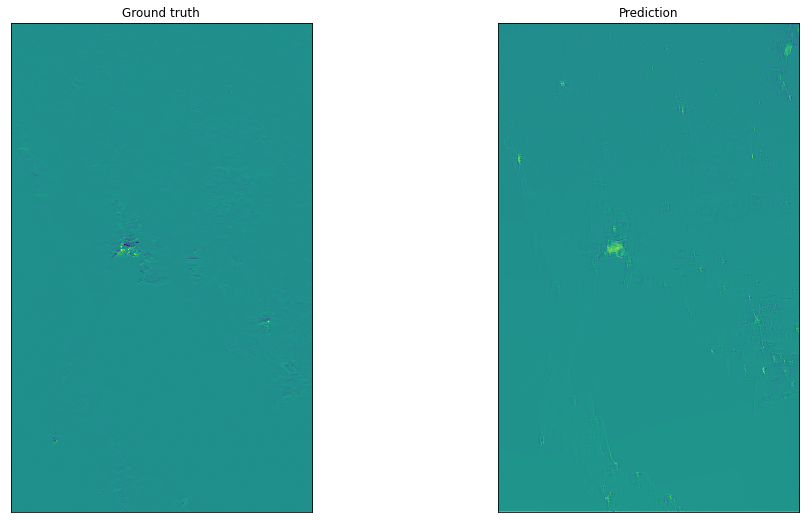

In [ ]:
fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_subplot(121)
im1 = ax1.imshow(uv[1, :, :, 0], vmin=-2, vmax=2)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax1.set_title('Ground truth')

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(pred[..., 2], vmin=-2, vmax=2)
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
ax2.set_title('Prediction')

In [ ]:
np.any(encoding)

True

In [ ]:
encoding.shape

(1796, 1105, 16)

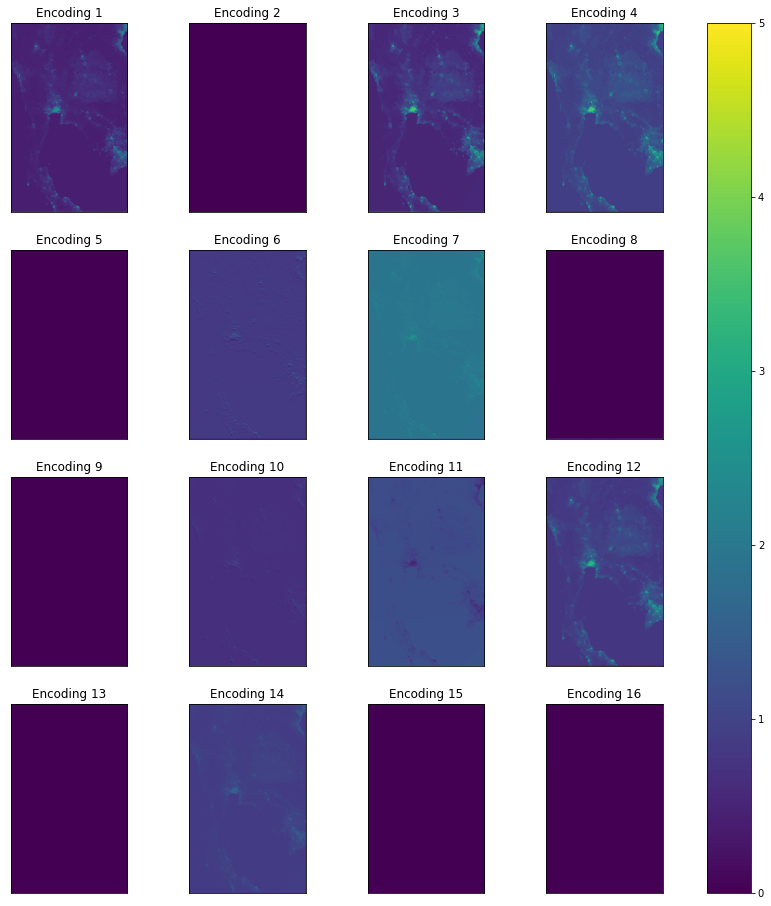

In [ ]:
fig = plt.figure(figsize=(16, 16))
axes = []

for i in range(16):
  ax = fig.add_subplot(4, 4, i+1)
  im = ax.imshow(encoding[..., i], vmin=0, vmax=5)
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
  ax.set_title(f'Encoding {i+1}')
  axes.append(ax)

fig.subplots_adjust(wspace=0, hspace=0.2)
fig.colorbar(im, ax=axes)

## 4. Install packages for geographical plotting

In [ ]:
!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely
!pip install shapely --no-binary shapely

Selecting previously unselected package python-pkg-resources.
(Reading database ... 155676 files and directories currently installed.)
Preparing to unpack .../00-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-pyshp.
Preparing to unpack .../01-python-pyshp_1.2.12+ds-1_all.deb ...
Unpacking python-pyshp (1.2.12+ds-1) ...
Selecting previously unselected package python-shapely.
Preparing to unpack .../02-python-shapely_1.6.4-1_amd64.deb ...
Unpacking python-shapely (1.6.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../03-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-cartopy:amd64.
Preparing to unpack .../04-python-cartopy_0.14.2+dfsg1-2build3_amd64.deb ...
Unpacking python-cartopy:amd64 (0.14.2+dfsg1-2build3) ...
Selecting previously unselected package python3-numpy.
Preparing to unpack .../05-python

In [ ]:
!pip install scitools-iris

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.2 MB 11.6 MB/s 
     |████████████████████████████████| 474 kB 72.3 MB/s 
     |████████████████████████████████| 10.8 MB 53.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 12.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 39.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 33.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 53.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |██

## 5. Geographical plotting

In [ ]:
import iris
import iris.plot as iplt
import cartopy.crs as ccrs

In [ ]:
from iris.coords import DimCoord
from iris.cube import Cube

In [ ]:
long_start = 97.0
lat_start = 20.6
long_end = 106.2
lat_end = 5.7

In [ ]:
threshold = 0.9999
mag = uv[0]**2 + uv[1]**2
mask = mag >= np.quantile(mag, threshold, axis=(0, 1))
uv_th = uv[:, mask]
X = np.array(np.where(mask))
X_frames = [X[:-1, X[2] == i] for i in range(5)]
uv_th_frames = [uv_th[:, X[2] == i] for i in range(5)]

In [ ]:
p_mag = pred[..., 1]**2 + pred[..., 2]**2
p_mask = p_mag >= np.quantile(p_mag, threshold, axis=(0, 1))
p_uv_th = pred[p_mask, 1:]
p_X = np.array(np.where(p_mask))

In [ ]:
latitude = DimCoord(np.linspace(lat_start, lat_end, gpw.shape[0]), standard_name='latitude', units='degrees')
longitude = DimCoord(np.linspace(long_start, long_end, gpw.shape[1]), standard_name='longitude', units='degrees')

In [ ]:
dummy_cube = Cube(np.zeros(gpw.shape[:2], dtype=np.float32), dim_coords_and_dims=[(latitude, 0), (longitude, 1)])

In [ ]:
lat_reduce = latitude.points[X_frames[0][0, :]]
lon_reduce = longitude.points[X_frames[1][1, :]]

In [ ]:
p_lat_reduce = latitude.points[p_X[0]]
p_lon_reduce = longitude.points[p_X[1]]

/usr/local/lib/python3.7/dist-packages/iris/coords.py:1808: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  "contiguous bounds.".format(self.name())
/usr/local/lib/python3.7/dist-packages/iris/coords.py:1808: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  "contiguous bounds.".format(self.name())


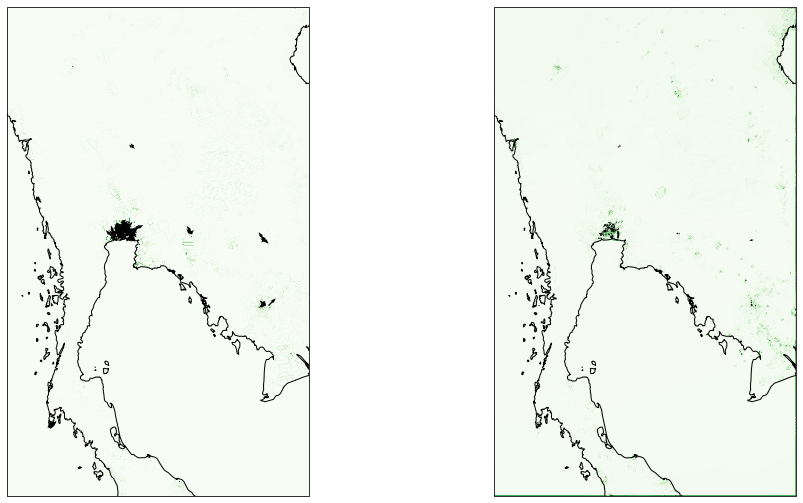

In [ ]:
fig = plt.figure(figsize=(16, 9))
crs_latlon = ccrs.PlateCarree()

quiver_kwargs = {'headwidth': 2.5, 'headlength': 3.5, 'scale': 50,
                 'scale_units': 'xy', 'angles': 'uv', 'zorder': 2,
                 'rasterized': None}
cmesh_kwargs = {'cmap': 'Greens', 'vmin': 0, 'vmax': 3}

u_cube = dummy_cube.copy(data=uv[0, :, :, 0])
v_cube = dummy_cube.copy(data=uv[1, :, :, 0])

w = (u_cube**2 + v_cube**2) ** 0.5

ax1 = fig.add_subplot(121, projection=crs_latlon)

plt.quiver(lon_reduce, lat_reduce, *uv_th_frames[0], **quiver_kwargs)
cmesh = iplt.pcolormesh(w, **cmesh_kwargs)

ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax1.set_xlim(long_start, long_end)
ax1.set_ylim(lat_end, lat_start)
ax1.coastlines()

p_u_cube = dummy_cube.copy(data=pred[..., 1])
p_v_cube = dummy_cube.copy(data=pred[..., 2])
p_w = (p_u_cube**2 + p_v_cube**2) ** 0.5

ax2 = fig.add_subplot(122, projection=crs_latlon)

plt.quiver(lon_reduce, lat_reduce, pred[mask[..., 0], 1], pred[mask[..., 0], 2], **quiver_kwargs)
cmesh = iplt.pcolormesh(p_w, **cmesh_kwargs)

ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
ax2.set_xlim(long_start, long_end)
ax2.set_ylim(lat_end, lat_start)
ax2.coastlines()

In [ ]:
uv.shape

(2, 1796, 1105, 5)

In [ ]:
(np.square(uv[..., 0] - np.moveaxis(pred[..., 1:], -1, 0))).mean()

0.028847813285217423